In [13]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm, multivariate_normal
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
from scipy.optimize import minimize

import matplotlib.pylab as pylab
params = {'legend.fontsize': 25,
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':'x-large',
          'axes.titlesize' : 'x-large'}
pylab.rcParams.update(params)
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg

Generate DAG data

In [51]:
obs_per_graph = 1000
X = np.zeros((obs_per_graph, 5))
sigma = 0.1
rnd = np.random.RandomState(42)

A  = np.array([[0,0,0,0,0],
                [0.4, 0.0,0,0,0], 
                [0,0.35 , 0.0, 0,0], 
                [0.0, 0.0, 0.5, 0,0],
                [0, 0, 0, 0.3, 0]])

I = np.identity(X.shape[1])

W = np.linalg.inv(I-A)

for i in range(obs_per_graph):
    # X[i,0] =  rnd.normal(0,1)
    # X[i,1] = np.dot(W[1], X[i]) + rnd.normal(0,1)
    # X[i,2] = np.dot(W[2], X[i]) + rnd.normal(0,1)
    # X[i,3] = np.dot(W[3], X[i]) + rnd.normal(0,1)
    # X[i,4] = np.dot(W[4], X[i]) + rnd.normal(0,1)

    X[i] = np.dot(A+I, np.random.normal(0,1,5))




I = np.identity(X.shape[1])
np.linalg.cond(W)
# for i in range(obs_per_graph):
#     X[i,1] = rnd.normal(0,1)
#     X[i,2] = 0.5*X[i,1] + rnd.normal(0,1)
#     X[i,3] = 0.2*X[i,1] + rnd.normal(0,1)
#     X[i,4] = 0.25*X[i,2] + 0.1*X[i,3] + rnd.normal(0,1)
#     X[i,0] =  0.3*X[i,3] + rnd.normal(0,1)

2.033763808268411

In [11]:
I + A + np.dot(A,A) + np.dot(A,A).dot(A)  + np.dot(A,A).dot(A).dot(A) + np.dot(A,A).dot(A).dot(A).dot(A)

array([[1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.2  , 1.   , 0.   , 0.   , 0.   ],
       [0.06 , 0.3  , 1.   , 0.   , 0.   ],
       [0.03 , 0.15 , 0.5  , 1.   , 0.   ],
       [0.009, 0.045, 0.15 , 0.3  , 1.   ]])

In [12]:
np.linalg.cond(W)

1.9186185569575491

In [13]:
W

array([[1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.2  , 1.   , 0.   , 0.   , 0.   ],
       [0.06 , 0.3  , 1.   , 0.   , 0.   ],
       [0.03 , 0.15 , 0.5  , 1.   , 0.   ],
       [0.009, 0.045, 0.15 , 0.3  , 1.   ]])

True

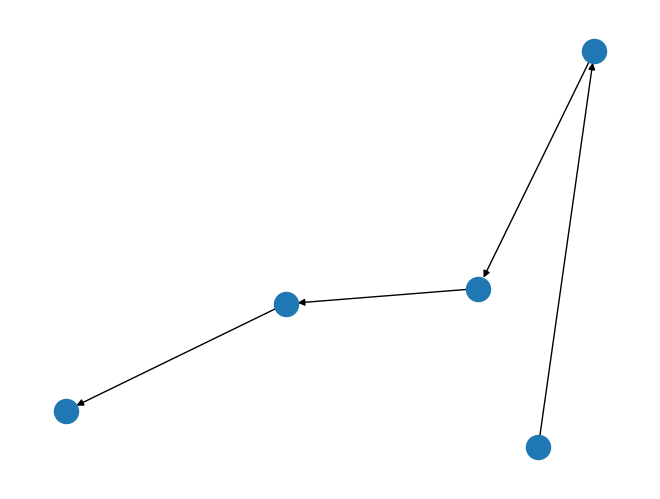

In [8]:
G = nx.from_numpy_array(A.T,create_using = nx.DiGraph)
nx.draw(G)
nx.is_directed_acyclic_graph(G)

# NO tears

In [1]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X


def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}



In [2]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid


def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est





In [42]:
A

array([[0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. ],
       [0. , 0.3, 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0.3, 0. ]])

In [60]:
A

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.4 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.35, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.3 , 0.  ]])

In [58]:
# set_random_seed(1)

n, d, s0, graph_type, sem_type = 10000, 5, 4, 'ER', 'gauss'
# B_true = simulate_dag(d, s0, graph_type)
# W_true = simulate_parameter(B_true)
# print(W_true)

X = simulate_linear_sem(A, n, sem_type)


W_est = notears_linear(X, lambda1=0.05, loss_type='l2')
W_est

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.36499464, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.30085123, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.45866795, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [61]:

init =  np.array([[0,0,0,0,0],
                [0, 0.0,0,0,0], 
                [0.2,0 , 0.0, 0,0], 
                [0.0, 0.0, 0, 0,0],
                [0, 0, 0, 0.1, 0]])

def likeli(param, X, alpha):
    I = np.identity(X.shape[1])
    A = np.reshape(param,(X.shape[1],X.shape[1]))
    np.fill_diagonal(A,0)
    IA_inv = np.linalg.inv(I-A)
    return -np.sum(multivariate_normal.logpdf(X, mean = np.zeros(X.shape[1]), cov = np.dot(IA_inv, IA_inv.T))) + alpha*np.sum(np.abs(A))
# likeli(z0[0].flatten(), theta[0], u0[0], rho, X)
out = minimize(likeli, init.flatten(), args = (X, 0.15*X.shape[0]))
np.set_printoptions(suppress=True)
np.round(np.reshape(out.x, (5,5)),2)

array([[ 0.  ,  0.28,  0.  , -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.22,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.29,  0.  ],
       [ 0.  ,  0.  ,  0.09,  0.  ,  0.  ],
       [-0.  , -0.  ,  0.  ,  0.14,  0.  ]])

In [17]:
I = np.identity(X.shape[1])
I - np.linalg.inv(W_true)

LinAlgError: Singular matrix

# Graphical dag

In [1]:

def soft_threshold_odd( A, lamda):

    """
    diagonal lasso penalty

    Parameters
    ------------------
    A: np.array,
    
    lamda: float,
        regularization
    """
    opt_m = (A-lamda)*(A>=lamda) + (A+lamda)*(A<=-lamda)
    

    return opt_m

def gen_low_tri():
    A = np.random.uniform(-0.5,0.5, size = (X.shape[1], X.shape[1]))
    return np.tril(A,0)

Can I use scipy optim to find the DAG?

In [326]:
np.linalg.cond(W)

1.9186185569575491

In [331]:

init =  np.array([[0,0,0,0,0],
                [0.1, 0.0,0,0,0], 
                [0.2,0.2 , 0.0, 0,0], 
                [0.0, 0.0, 0.1, 0,0],
                [0, 0, 0, 0.1, 0]])

def likeli(param, X, alpha):
    I = np.identity(X.shape[1])
    A = np.reshape(param,(X.shape[1],X.shape[1]))
    np.fill_diagonal(A,0)
    IA_inv = np.linalg.inv(I-A )
    return -np.sum(multivariate_normal.logpdf(X, mean = np.zeros(X.shape[1]), cov = np.dot(IA_inv, IA_inv.T))) + alpha*np.sum(np.abs(A))
# likeli(z0[0].flatten(), theta[0], u0[0], rho, X)
out = minimize(likeli, init.flatten(), args = (X, 0.1*X.shape[0]))
np.round(np.reshape(out.x, (5,5)),2)

array([[ 0.  ,  0.1 ,  0.  ,  0.  , -0.  ],
       [-0.  ,  0.  ,  0.18,  0.  , -0.  ],
       [-0.02,  0.  ,  0.  ,  0.14, -0.  ],
       [-0.  , -0.01,  0.38,  0.  ,  0.02],
       [ 0.  ,  0.  ,  0.02,  0.25,  0.  ]])

In [268]:
X

array([[ 0.49671415, -0.03892147,  0.66581495,  1.86500053,  0.42793799],
       [-0.23413696,  1.53238542,  1.21310214,  0.35991039,  0.89934859],
       [-0.46341769, -0.55841329,  0.04663322, -1.98762816, -2.34351065],
       ...,
       [ 0.85958789, -0.21521307, -0.05839987, -0.01030584, -1.93347318],
       [-0.01383775, -0.69249532, -0.70170168,  0.98849173, -1.09650146],
       [ 0.81320519, -0.11632189, -0.26586443,  0.66438756,  0.50157226]])

In [269]:
likeli(init.flatten(), X, 0.1)

3595.525322602367

In [112]:
z0 = np.array([ I- np.array([[0,0,0,0,0],
                [1, 0,0,0,0], 
                [0, 1.0, 0, 0,0], 
                [0, 0.0, 1.0, 0,0],
                [0, 0, 0, 1.0, 0]])])

In [126]:
np.reshape(z0[0].flatten(),(5,5))

array([[ 1.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.]])

In [140]:
I

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [153]:

from scipy.optimize import minimize
def likeli(param,theta,u,rho, X):
    param = np.reshape(param,(5,5))
    IA_inv = np.linalg.inv(param)
    return -np.sum(multivariate_normal.logpdf(X, mean = np.zeros(X.shape[1]), cov = np.dot(IA_inv, IA_inv.T))) + 0.5*rho*scipy.linalg.norm(theta - (I-param - u), ord = 'fro')**2

# likeli(z0[0].flatten(), theta[0], u0[0], rho, X)
out = minimize(likeli, z0[0].flatten(), args = (theta[0], u0[0], rho, X))


In [148]:
out.values

<function OptimizeResult.values>

In [209]:
from scipy.optimize import minimize
d = X.shape[1]
I = np.identity(X.shape[1])

u0 = np.zeros((1, X.shape[1], X.shape[1]))

z0 = np.array([ I- np.array([[0,0,0,0,0],
                [1, 0,0,0,0], 
                [0, 1.0, 0, 0,0], 
                [0, 0.0, 1.0, 0,0],
                [0, 0, 0, 1.0, 0]]) for  i in range(1)]) # np.array([gen_low_tri() for  i in range(1)])
theta = np.array([I-z0[i] for i in range(1) ])
rho = obs_per_graph

lamda = 0.1*obs_per_graph
grad_val = 0.0001





def likeli(param,theta,u,rho, X):
    param = np.reshape(param,(5,5))
    IA_inv = np.linalg.inv(param+0.1*I)
    return -np.sum(multivariate_normal.logpdf(X, mean = np.zeros(X.shape[1]), cov = np.dot(IA_inv, IA_inv.T))) + 0.5*rho*scipy.linalg.norm(theta - (I-param - u), ord = 'fro')**2

# likeli(z0[0].flatten(), theta[0], u0[0], rho, X)
out = minimize(likeli, z0[0].flatten(), args = (theta[0], u0[0], rho, X))

S = np.cov(X.T)
for _ in range(100):
    theta[0] = soft_threshold_odd(I-z0[0] - u0[0], lamda/rho/2)

    out = minimize(likeli, z0[0].flatten(), args = (theta[0], u0[0], rho, X))
    z0[0] = np.reshape(out.x, (5,5))

    # update z0
    # for _ in range(10):
        #D = I#np.diag(np.reciprocal(np.diag(S)))
        #z0_inv = np.linalg.inv(z0[0])
        # grad = -2*z0_inv+ 2*np.dot(S, z0[0]).dot(D) +(rho/obs_per_graph)*(theta[0] - (I-z0[0] - u0[0]))
        # grad[np.triu_indices(grad.shape[0],1)] = 0
        
        #z0[0] = z0[0] - grad_val*grad


        # update u
    
    u0[0] = u0[0] - I + z0[0] + theta[0]

np.round(theta[0],2)

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [210]:
theta[0] 

array([[162.36792171,  -7.95482257, -50.6309705 ,  23.75315392,
         -3.11848664],
       [-41.61902933,  -4.49426347, -51.58031127, -19.13683909,
          4.04156967],
       [-22.38183906, -96.9310238 ,  27.53178121,  14.30404917,
         -2.62742009],
       [-45.3551515 ,  54.24817921,  -9.22244245,  31.50411667,
         -4.75022752],
       [-23.58393822,  -9.36156141,   4.76379784,  57.26673727,
         -7.42120051]])

In [109]:

IA_inv = np.linalg.inv(I -A)
-np.sum(multivariate_normal.logpdf(X, mean = np.zeros(X.shape[1]), cov = np.dot(IA_inv, IA_inv.T)))

3844.3496059059335

In [101]:
z0[0]

array([[ 1.23840555, -0.10254184, -0.07240881, -0.08055169, -0.10856816],
       [-0.1638453 ,  1.07915162, -0.11665455, -0.05702967, -0.17342124],
       [-0.0480302 , -0.1866373 ,  1.17819159, -0.11247163, -0.26681838],
       [-0.08474864, -0.03878493, -0.22568925,  1.15375003, -0.36213351],
       [-0.10919724, -0.16970385, -0.22009608, -0.40758308,  0.79950642]])

# No tears

In [419]:
obs_per_graph = 500
X = np.zeros((obs_per_graph, 5))
sigma = 0.1
rnd = np.random.RandomState(42)
for i in range(obs_per_graph):
    X[i,0] = 1 # rnd.normal(0,1)
    X[i,1] = 0.7*X[i,0] + rnd.normal(0,sigma)
    X[i,2] = 0.5*X[i,0] + rnd.normal(0,sigma)
    X[i,3] = 0.45*X[i,1] + 0.3*X[i,2] + rnd.normal(0,sigma)
    X[i,4] =  0.6*X[i,2] + rnd.normal(0,sigma)


theta_true = np.array([[1,0,0,0,0],
                       [0.7, 1,0,0,0], 
                       [0.5, 0, 1, 0,0], 
                       [0, 0.45, 0.3, 1,0],
                       [0, 0, 0.6, 0, 1]])

In [424]:
def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    E = expm(W * W)  # (Zheng et al. 2018)
    h = np.trace(E) - W.shape[0]
    #     # A different formulation, slightly faster at the cost of numerical stability
    #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
    #     E = np.linalg.matrix_power(M, d - 1)
    #     h = (E.T * M).sum() - d
    G_h = E.T * W * 2
    return h, G_h


from scipy.linalg import expm

I = np.identity(X.shape[1])
d = X.shape[1]

u0 = 0.1*np.ones((1, X.shape[1], X.shape[1]))
np.fill_diagonal(u0[0],0)
u1 = 0.1*np.zeros((1, X.shape[1], X.shape[1]))
np.fill_diagonal(u1[0],0)

# np.random.uniform(0,0.5,size=(d,d))
z0 = np.array([theta_true for  i in range(1)])
z1 = np.array([theta_true for  i in range(1)])
theta = np.array([theta_true for i in range(1) ])
np.fill_diagonal(z0[0],0)
np.fill_diagonal(z1[0],0)
np.fill_diagonal(theta[0],0)
rho = 0.001  # obs_per_graph

lamda = 0.2*rho
grad_val = 0.1

S = np.dot(X.T,X)/500
for _ in range(1000):

    S_inv = np.linalg.inv(S +2*rho*I)
    theta[0] =  np.dot(S_inv, S + rho*z0[0]+ rho*z1[0]- rho*u0[0]- rho*u1[0])
    np.fill_diagonal(theta[0],0)
    
    z0[0] = soft_threshold_odd(theta[0] + u0[0], lamda/rho)

    #     # update z1
    for _ in range(50):
        h , _ = _h(z1[0])
        grad =  2*h*2*expm(z1[0] * z1[0])*z1[0] + (rho/10)*(theta[0]-z1[0]+u1[0])
        z1[0] = z1[0] - grad_val*grad


    # update u
    u0[0] = u0[0] + theta[0]-z0[0]
    u1[0] = u1[0] + theta[0]-z1[0]



h_val, _ = _h(theta[0])
print(h_val)
np.set_printoptions(suppress=True)
print("theta")
print(np.round(theta[0],2))
print("z0")
print(np.round(z0[0],2))
print("z1")
print(np.round(z1[0],2))

0.027735178609331612
theta
[[ 0.   -0.19  0.25 -0.33 -0.46]
 [-0.11  0.    0.24 -0.28 -0.42]
 [ 0.1  -0.18  0.   -0.26 -0.36]
 [ 0.08 -0.16  0.2   0.   -0.37]
 [ 0.12 -0.17  0.1  -0.23  0.  ]]
z0
[[ 0.   -0.19  0.25 -0.33 -0.46]
 [-0.11  0.    0.24 -0.28 -0.42]
 [ 0.1  -0.18  0.   -0.26 -0.36]
 [ 0.08 -0.16  0.2   0.   -0.37]
 [ 0.12 -0.17  0.1  -0.23  0.  ]]
z1
[[ 0.   -0.2   0.25 -0.32 -0.5 ]
 [-0.11  0.    0.24 -0.28 -0.45]
 [ 0.1  -0.19  0.   -0.26 -0.37]
 [ 0.08 -0.17  0.2   0.   -0.39]
 [ 0.12 -0.18  0.1  -0.23  0.  ]]


In [399]:
scipy.linalg.norm(X-np.dot(X,theta[0]))**2/obs_per_graph/2

1.8997736426727307

In [389]:
S

array([[0.9399088 , 0.66157758, 0.52692463, 0.47697861, 0.29346212],
       [0.66157758, 1.54265381, 0.37910093, 0.76550327, 0.25216049],
       [0.52692463, 0.37910093, 1.19323098, 0.53570081, 0.72616871],
       [0.47697861, 0.76550327, 0.53570081, 1.39875979, 0.29958836],
       [0.29346212, 0.25216049, 0.72616871, 0.29958836, 1.44661653]])

In [411]:
np.fill_diagonal(theta_true,0)
_h(theta_true)

(0.0,
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))

In [412]:
theta_true
scipy.linalg.norm(X-np.dot(X,theta_true))**2/obs_per_graph/2

0.3300910227002849

In [413]:
scipy.linalg.norm(X-np.dot(X,theta[0]))**2/obs_per_graph/2

1.1479587766404544

In [338]:

_h(theta_true)

(0.0,
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))